<a href="https://colab.research.google.com/github/pallavi-2000/MALLORN_challenge/blob/main/mallorn_v5_golden_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌟 MALLORN V5: Physics-Based Golden Features

## Strategy: Feature Engineering > Augmentation

Based on competition discussion: *"Focus on light curve features that distinguish TDE from SN and AGN, especially the shape."*

### TDE vs SN vs AGN - Key Physical Differences

| Feature | TDE | Supernova | AGN |
|---------|-----|-----------|-----|
| Rise time | **Slow (weeks-months)** | Fast (~2 weeks) | Stochastic |
| Decay | **t^(-5/3) power law** | Exponential | Random |
| Duration | 100-300+ days | 50-100 days | Years |
| Color | **Very blue (u-band strong)** | Varies | Redder |
| Symmetry | **Asymmetric (decay >> rise)** | More symmetric | N/A |
| Smoothness | **Very smooth** | Smooth | **Stochastic/flickering** |
| Temperature | **~30,000-50,000K (hot!)** | ~10,000K | Variable |

### V5 Approach
1. **NO augmentation** (lessons learned: it hurts)
2. Focus on **shape-based discriminative features**
3. Add **temperature proxy** via color at peak
4. Add **TDE-specific decay fitting**
5. Add **AGN stochasticity detectors**

In [ ]:
# CELL 1: Install Dependencies
!pip install -q lightgbm xgboost extinction kaggle
print("✅ Dependencies installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.8/627.8 kB 10.0 MB/s eta 0:00:00
✅ Dependencies installed!


In [ ]:
# CELL 2: Setup Kaggle API
from google.colab import files
import os

os.makedirs('/root/.kaggle', exist_ok=True)
print("📤 Please upload your kaggle.json file:")
uploaded = files.upload()
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
print("\n✅ Kaggle API configured!")

📤 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

✅ Kaggle API configured!


In [ ]:
# CELL 3: Download Data
!mkdir -p /content/mallorn_data
print("📥 Downloading MALLORN competition data...")
!kaggle competitions download -c mallorn-astronomical-classification-challenge -p /content/mallorn_data
print("\n📦 Extracting data...")
!cd /content/mallorn_data && unzip -q -o mallorn-astronomical-classification-challenge.zip
print("\n✅ Data downloaded and extracted!")

📥 Downloading MALLORN competition data...
  0% 0.00/25.5M [00:00<?, ?B/s]
100% 25.5M/25.5M [00:00<00:00, 1.13GB/s]

📦 Extracting data...

✅ Data downloaded and extracted!


In [ ]:
# CELL 4: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy import stats
from scipy.interpolate import interp1d
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import lightgbm as lgb
import xgboost as xgb

from extinction import fitzpatrick99

print("✅ All imports successful!")

✅ All imports successful!


In [ ]:
# CELL 5: Configuration
DATA_PATH = '/content/mallorn_data'

# LSST filter effective wavelengths (Angstroms)
FILTER_WAVELENGTHS = {
    'u': 3641, 'g': 4704, 'r': 6155,
    'i': 7504, 'z': 8695, 'y': 10056
}

# Physics constants
TDE_DECAY_INDEX = -5/3  # Theoretical t^(-5/3) fallback rate

N_FOLDS = 5
RANDOM_STATE = 42

print("✅ Configuration set!")

✅ Configuration set!


In [ ]:
# CELL 6: Load Data
print("="*70)
print("LOADING DATA")
print("="*70)

train_log = pd.read_csv(f'{DATA_PATH}/train_log.csv')
test_log = pd.read_csv(f'{DATA_PATH}/test_log.csv')

print(f"✅ Training objects: {len(train_log)}")
print(f"✅ Test objects: {len(test_log)}")
print(f"\n📊 Class distribution:")
print(f"   TDE: {train_log['target'].sum()} ({100*train_log['target'].mean():.2f}%)")
print(f"   Non-TDE: {(train_log['target'] == 0).sum()}")

# Check SpecType distribution
if 'SpecType' in train_log.columns:
    print(f"\n📊 Spectral types:")
    print(train_log['SpecType'].value_counts())

# Load lightcurves
train_lightcurves = {}
test_lightcurves = {}
splits = [f'split_{i:02d}' for i in range(1, 21)]

for split in tqdm(splits, desc="Loading splits"):
    train_path = f'{DATA_PATH}/{split}/train_full_lightcurves.csv'
    test_path = f'{DATA_PATH}/{split}/test_full_lightcurves.csv'
    if os.path.exists(train_path):
        train_lightcurves[split] = pd.read_csv(train_path)
    if os.path.exists(test_path):
        test_lightcurves[split] = pd.read_csv(test_path)

print(f"\n✅ Loaded {len(train_lightcurves)} splits")

LOADING DATA
✅ Training objects: 3043
✅ Test objects: 7135

📊 Class distribution:
   TDE: 148 (4.86%)
   Non-TDE: 2895

📊 Spectral types:
SpecType
AGN                  1786
SN Ia                 790
SN II                 163
TDE                   148
SN IIn                 41
SN Ic                  21
SN Ia-91T-like         17
SLSN-I                 15
SN Ic-BL               12
SLSN-II                10
SN Ib                   9
SN Ia-pec               8
SN IIb                  8
SN IIP                  6
SN Iax[02cx-like]       5
SN Ia-91bg-like         4
Name: count, dtype: int64


Loading splits:   0%|          | 0/20 [00:00<?, ?it/s]


✅ Loaded 20 splits


In [ ]:
# CELL 7: Helper Functions

def deextinct_flux(flux, ebv, filter_name):
    """Remove Milky Way dust extinction from flux."""
    if pd.isna(ebv) or ebv <= 0:
        return np.array(flux)
    wavelength = np.array([FILTER_WAVELENGTHS[filter_name]])
    A_lambda = fitzpatrick99(wavelength, float(ebv) * 3.1)
    return np.array(flux) * 10**(A_lambda[0] / 2.5)

def get_lightcurve(object_id, log_df, lightcurves_dict):
    """Get lightcurve data for an object."""
    obj_info = log_df[log_df['object_id'] == object_id]
    if len(obj_info) == 0:
        return None, None
    split = obj_info['split'].values[0]
    if split not in lightcurves_dict:
        return None, obj_info.iloc[0]
    lc = lightcurves_dict[split]
    return lc[lc['object_id'] == object_id].copy(), obj_info.iloc[0]

print("✅ Helper functions defined!")

✅ Helper functions defined!


In [ ]:
# CELL 8: Model Functions for Fitting

def bazin_function(t, A, t0, t_fall, t_rise, c):
    """Bazin model for supernova-like transients."""
    return A * np.exp(-(t - t0) / t_fall) / (1 + np.exp(-(t - t0) / t_rise)) + c

def tde_decay_model(t, A, t0, alpha):
    """TDE power-law decay model: F(t) = A * (t - t0)^alpha
    For TDE: alpha should be close to -5/3 ≈ -1.67
    """
    t_shifted = np.maximum(t - t0, 0.1)  # Avoid division by zero
    return A * np.power(t_shifted, alpha)

def gaussian_rise_powerlaw_decay(t, A, t_peak, sigma_rise, alpha_decay):
    """Combined model: Gaussian rise + power-law decay
    This captures TDE-like behavior better than Bazin.
    """
    result = np.zeros_like(t, dtype=float)

    # Rising phase (before peak)
    rising = t <= t_peak
    result[rising] = A * np.exp(-0.5 * ((t[rising] - t_peak) / sigma_rise)**2)

    # Decay phase (after peak)
    decaying = t > t_peak
    t_decay = t[decaying] - t_peak + 1  # +1 to avoid t=0
    result[decaying] = A * np.power(t_decay, alpha_decay)

    return result

print("✅ Model functions defined!")

✅ Model functions defined!


In [ ]:
# CELL 9: GOLDEN FEATURE EXTRACTION

def extract_golden_features(lc_df, info):
    """
    V5 GOLDEN FEATURES - Physics-based discriminators

    Key discriminators:
    1. SHAPE: Rise time, decay rate, asymmetry (TDE vs SNe)
    2. COLOR: u-band strength, color at peak (TDE is BLUE)
    3. STOCHASTICITY: Smoothness metrics (TDE vs AGN)
    4. POWER-LAW: Deviation from t^(-5/3) decay (TDE signature)
    5. DURATION: Total evolution timescale (TDE is long)
    """
    features = {}

    if lc_df is None or len(lc_df) == 0:
        return None

    time = lc_df['Time (MJD)'].values
    flux = lc_df['Flux'].values
    flux_err = lc_df['Flux_err'].values
    bands = lc_df['Filter'].values

    z = info['Z'] if pd.notna(info['Z']) else 0
    ebv = info['EBV'] if pd.notna(info['EBV']) else 0

    # Organize by band with de-extinction
    lc_dict = {}
    for filt in ['u', 'g', 'r', 'i', 'z', 'y']:
        mask = bands == filt
        if mask.sum() > 0:
            f_time = time[mask]
            f_flux = deextinct_flux(flux[mask], ebv, filt)
            f_err = flux_err[mask]
            # Sort by time
            sort_idx = np.argsort(f_time)
            lc_dict[filt] = {
                'time': f_time[sort_idx],
                'flux': f_flux[sort_idx],
                'flux_err': f_err[sort_idx]
            }

    # ==========================================
    # SECTION 1: BASIC STATISTICS
    # ==========================================
    features['n_obs'] = len(flux)
    features['n_bands'] = len(lc_dict)
    features['duration'] = time.max() - time.min()
    features['flux_mean'] = np.mean(flux)
    features['flux_std'] = np.std(flux)
    features['flux_max'] = np.max(flux)
    features['flux_min'] = np.min(flux)
    features['flux_range'] = features['flux_max'] - features['flux_min']
    features['snr_median'] = np.median(flux / (flux_err + 1e-10))

    # ==========================================
    # SECTION 2: GOLDEN FEATURE - RISE & DECAY TIMES
    # TDE: slow rise (weeks-months), very slow decay (months-years)
    # SNe: fast rise (~2 weeks), faster decay
    # ==========================================
    for filt in ['g', 'r']:
        prefix = f'{filt}_'
        if filt not in lc_dict or len(lc_dict[filt]['time']) < 5:
            for key in ['rise_time', 'decay_time', 'asymmetry', 'rise_rate',
                       'decay_rate', 'peak_flux', 'fwhm', 't10_t90']:
                features[f'{prefix}{key}'] = np.nan
            continue

        f_time = lc_dict[filt]['time']
        f_flux = lc_dict[filt]['flux']

        peak_idx = np.argmax(f_flux)
        peak_flux = f_flux[peak_idx]
        peak_time = f_time[peak_idx]

        features[f'{prefix}peak_flux'] = peak_flux

        # Rise time (first obs to peak)
        rise_time = peak_time - f_time[0]
        features[f'{prefix}rise_time'] = rise_time

        # Decay time (peak to last obs)
        decay_time = f_time[-1] - peak_time
        features[f'{prefix}decay_time'] = decay_time

        # Asymmetry: decay/rise ratio (TDE >> 1, SNe ~ 1-3)
        if rise_time > 1:
            features[f'{prefix}asymmetry'] = decay_time / rise_time
        else:
            features[f'{prefix}asymmetry'] = np.nan

        # Rise rate (flux change per day during rise)
        if rise_time > 1 and peak_idx > 0:
            rise_amount = peak_flux - f_flux[0]
            features[f'{prefix}rise_rate'] = rise_amount / rise_time
        else:
            features[f'{prefix}rise_rate'] = np.nan

        # Decay rate (flux change per day during decay)
        if decay_time > 1 and peak_idx < len(f_flux) - 1:
            decay_amount = peak_flux - f_flux[-1]
            features[f'{prefix}decay_rate'] = decay_amount / decay_time
        else:
            features[f'{prefix}decay_rate'] = np.nan

        # FWHM (Full Width at Half Maximum)
        half_max = peak_flux / 2
        above_half = f_time[f_flux > half_max]
        if len(above_half) >= 2:
            features[f'{prefix}fwhm'] = above_half.max() - above_half.min()
        else:
            features[f'{prefix}fwhm'] = 0

        # t10-t90: time between 10% and 90% of peak
        # This captures the overall evolution timescale
        above_10 = f_time[f_flux > 0.1 * peak_flux]
        above_90 = f_time[f_flux > 0.9 * peak_flux]
        if len(above_10) >= 2:
            features[f'{prefix}t10_t90'] = above_10.max() - above_10.min()
        else:
            features[f'{prefix}t10_t90'] = 0

    # ==========================================
    # SECTION 3: GOLDEN FEATURE - POWER-LAW DECAY INDEX
    # TDE decay ~ t^(-5/3) = t^(-1.67)
    # ==========================================
    for filt in ['g', 'r']:
        prefix = f'{filt}_'
        if filt not in lc_dict or len(lc_dict[filt]['time']) < 10:
            features[f'{prefix}decay_power_index'] = np.nan
            features[f'{prefix}tde_index_match'] = np.nan
            features[f'{prefix}decay_power_r2'] = np.nan
            continue

        f_time = lc_dict[filt]['time']
        f_flux = lc_dict[filt]['flux']

        peak_idx = np.argmax(f_flux)

        # Get decay phase data (after peak)
        decay_mask = np.arange(len(f_time)) > peak_idx
        if decay_mask.sum() >= 5:
            t_decay = f_time[decay_mask] - f_time[peak_idx] + 1  # Shift to avoid log(0)
            f_decay = f_flux[decay_mask]

            # Only use positive flux values for log fitting
            pos_mask = f_decay > 0
            if pos_mask.sum() >= 5:
                try:
                    # Fit log(F) = log(A) + alpha * log(t)
                    log_t = np.log(t_decay[pos_mask])
                    log_f = np.log(f_decay[pos_mask])

                    # Linear regression
                    slope, intercept, r_value, _, _ = stats.linregress(log_t, log_f)

                    features[f'{prefix}decay_power_index'] = slope
                    features[f'{prefix}decay_power_r2'] = r_value**2

                    # How close to TDE theoretical index?
                    # Lower = more TDE-like
                    features[f'{prefix}tde_index_match'] = abs(slope - TDE_DECAY_INDEX)
                except:
                    features[f'{prefix}decay_power_index'] = np.nan
                    features[f'{prefix}tde_index_match'] = np.nan
                    features[f'{prefix}decay_power_r2'] = np.nan
            else:
                features[f'{prefix}decay_power_index'] = np.nan
                features[f'{prefix}tde_index_match'] = np.nan
                features[f'{prefix}decay_power_r2'] = np.nan
        else:
            features[f'{prefix}decay_power_index'] = np.nan
            features[f'{prefix}tde_index_match'] = np.nan
            features[f'{prefix}decay_power_r2'] = np.nan

    # ==========================================
    # SECTION 4: GOLDEN FEATURE - COLOR (TDE IS BLUE!)
    # TDE: Strong u-band, blue colors
    # AGN: Redder
    # ==========================================

    # u-band strength relative to r-band (TDE signature!)
    if 'u' in lc_dict and 'r' in lc_dict:
        u_max = np.max(lc_dict['u']['flux'])
        r_max = np.max(lc_dict['r']['flux'])
        features['u_r_max_ratio'] = u_max / (r_max + 1e-10)

        u_mean = np.mean(lc_dict['u']['flux'])
        r_mean = np.mean(lc_dict['r']['flux'])
        features['u_r_mean_ratio'] = u_mean / (r_mean + 1e-10)
    else:
        features['u_r_max_ratio'] = np.nan
        features['u_r_mean_ratio'] = np.nan

    # g-r color (proxy for temperature - TDE is hotter = bluer)
    if 'g' in lc_dict and 'r' in lc_dict:
        g_flux = lc_dict['g']['flux']
        r_flux = lc_dict['r']['flux']
        g_time = lc_dict['g']['time']
        r_time = lc_dict['r']['time']

        # g/r ratio (higher = bluer = hotter)
        features['g_r_max_ratio'] = np.max(g_flux) / (np.max(r_flux) + 1e-10)
        features['g_r_mean_ratio'] = np.mean(g_flux) / (np.mean(r_flux) + 1e-10)

        # Color at peak (important discriminator!)
        # Find g-r color near peak brightness
        r_peak_idx = np.argmax(r_flux)
        r_peak_time = r_time[r_peak_idx]

        # Find g flux near peak time
        g_near_peak = np.abs(g_time - r_peak_time) < 10
        if g_near_peak.sum() > 0:
            g_at_peak = np.mean(g_flux[g_near_peak])
            r_at_peak = r_flux[r_peak_idx]
            features['g_r_at_peak'] = g_at_peak / (r_at_peak + 1e-10)
        else:
            features['g_r_at_peak'] = np.nan

        # Color evolution (TDE stays blue longer)
        # Sample color at different phases
        for phase in [30, 60, 100]:
            target_time = r_peak_time + phase
            g_near = np.abs(g_time - target_time) < 15
            r_near = np.abs(r_time - target_time) < 15

            if g_near.sum() > 0 and r_near.sum() > 0:
                features[f'g_r_color_{phase}d'] = np.mean(g_flux[g_near]) / (np.mean(r_flux[r_near]) + 1e-10)
            else:
                features[f'g_r_color_{phase}d'] = np.nan
    else:
        for key in ['g_r_max_ratio', 'g_r_mean_ratio', 'g_r_at_peak',
                   'g_r_color_30d', 'g_r_color_60d', 'g_r_color_100d']:
            features[key] = np.nan

    # ==========================================
    # SECTION 5: GOLDEN FEATURE - STOCHASTICITY (AGN DETECTOR)
    # TDE: Smooth single flare
    # AGN: Stochastic, flickering, multiple peaks
    # ==========================================
    for filt in ['g', 'r']:
        prefix = f'{filt}_'
        if filt not in lc_dict or len(lc_dict[filt]['flux']) < 10:
            for key in ['flux_scatter', 'chi2_smooth', 'n_local_peaks',
                       'largest_dip_frac', 'flux_ratio_std']:
                features[f'{prefix}{key}'] = np.nan
            continue

        f_time = lc_dict[filt]['time']
        f_flux = lc_dict[filt]['flux']
        f_err = lc_dict[filt]['flux_err']

        # Excess scatter beyond measurement errors
        # AGN has more excess scatter
        expected_var = np.mean(f_err**2)
        actual_var = np.var(f_flux)
        features[f'{prefix}flux_scatter'] = (actual_var - expected_var) / (np.mean(f_flux)**2 + 1e-10)

        # Chi^2 against a smooth model (running mean)
        # Higher = more stochastic = more AGN-like
        window = min(5, len(f_flux) // 3)
        if window >= 2:
            smooth = np.convolve(f_flux, np.ones(window)/window, mode='valid')
            if len(smooth) > 0:
                # Pad smooth to match original length
                pad_left = (len(f_flux) - len(smooth)) // 2
                pad_right = len(f_flux) - len(smooth) - pad_left
                smooth_padded = np.pad(smooth, (pad_left, pad_right), mode='edge')
                residuals = (f_flux - smooth_padded) / (f_err + 1e-10)
                features[f'{prefix}chi2_smooth'] = np.mean(residuals**2)
            else:
                features[f'{prefix}chi2_smooth'] = np.nan
        else:
            features[f'{prefix}chi2_smooth'] = np.nan

        # Number of local peaks (AGN has many, TDE has 1)
        diffs = np.diff(f_flux)
        sign_changes = np.where(diffs[:-1] * diffs[1:] < 0)[0]
        local_maxima = [i+1 for i in sign_changes if diffs[i] > 0 and diffs[i+1] < 0]
        features[f'{prefix}n_local_peaks'] = len(local_maxima)

        # Largest dip below peak as fraction of peak
        # TDE monotonically decays, AGN may have dips
        peak_flux = np.max(f_flux)
        peak_idx = np.argmax(f_flux)
        if peak_idx < len(f_flux) - 1:
            post_peak_min = np.min(f_flux[peak_idx:])
            post_peak_max = np.max(f_flux[peak_idx:])
            features[f'{prefix}largest_dip_frac'] = (post_peak_max - post_peak_min) / (peak_flux + 1e-10)
        else:
            features[f'{prefix}largest_dip_frac'] = 0

        # Flux ratio variability (consecutive points)
        flux_ratios = f_flux[1:] / (f_flux[:-1] + 1e-10)
        features[f'{prefix}flux_ratio_std'] = np.std(flux_ratios)

    # ==========================================
    # SECTION 6: BAZIN FIT PARAMETERS
    # ==========================================
    for filt in ['g', 'r']:
        prefix = f'{filt}_baz_'
        if filt not in lc_dict or len(lc_dict[filt]['time']) < 10:
            for key in ['amplitude', 't0', 't_fall', 't_rise', 'baseline', 'rise_fall_ratio', 'fit_chi2']:
                features[f'{prefix}{key}'] = np.nan
            continue

        f_time = lc_dict[filt]['time']
        f_flux = lc_dict[filt]['flux']
        f_err = lc_dict[filt]['flux_err']

        try:
            t = f_time - f_time.min()
            peak_idx = np.argmax(f_flux)
            A_init = f_flux[peak_idx] - np.median(f_flux)
            t0_init = t[peak_idx]

            bounds = ([0, 0, 1, 1, -1000], [10000, t.max()+100, 1000, 500, 1000])
            popt, _ = curve_fit(
                bazin_function, t, f_flux,
                p0=[max(A_init, 0.1), t0_init, 100, 30, np.median(f_flux)],
                bounds=bounds, maxfev=3000
            )

            features[f'{prefix}amplitude'] = popt[0]
            features[f'{prefix}t0'] = popt[1]
            features[f'{prefix}t_fall'] = popt[2]
            features[f'{prefix}t_rise'] = popt[3]
            features[f'{prefix}baseline'] = popt[4]
            features[f'{prefix}rise_fall_ratio'] = popt[3] / (popt[2] + 0.01)

            # Fit quality
            predicted = bazin_function(t, *popt)
            chi2 = np.sum(((f_flux - predicted) / (f_err + 1e-10))**2) / len(f_flux)
            features[f'{prefix}fit_chi2'] = chi2

        except:
            for key in ['amplitude', 't0', 't_fall', 't_rise', 'baseline', 'rise_fall_ratio', 'fit_chi2']:
                features[f'{prefix}{key}'] = np.nan

    # ==========================================
    # SECTION 7: PER-BAND BASIC FEATURES
    # ==========================================
    for filt in ['u', 'g', 'r', 'i', 'z', 'y']:
        prefix = f'{filt}_'
        if filt not in lc_dict:
            for key in ['n_obs', 'flux_mean', 'flux_std', 'flux_max', 'amplitude']:
                features[f'{prefix}{key}'] = np.nan
            continue

        f_flux = lc_dict[filt]['flux']
        features[f'{prefix}n_obs'] = len(f_flux)
        features[f'{prefix}flux_mean'] = np.mean(f_flux)
        features[f'{prefix}flux_std'] = np.std(f_flux)
        features[f'{prefix}flux_max'] = np.max(f_flux)
        features[f'{prefix}amplitude'] = np.max(f_flux) - np.min(f_flux)

    # ==========================================
    # SECTION 8: REDSHIFT FEATURES
    # ==========================================
    features['redshift'] = z
    features['ebv'] = ebv

    # Rest-frame duration (corrected for time dilation)
    features['rest_duration'] = features['duration'] / (1 + z) if z > 0 else features['duration']

    # Luminosity distance proxy (higher z = larger distance = fainter if same intrinsic L)
    features['z_squared'] = z**2

    return features

print("✅ Golden feature extraction defined!")

✅ Golden feature extraction defined!


In [ ]:
# CELL 10: Extract Features
print("="*70)
print("EXTRACTING GOLDEN FEATURES")
print("="*70)

# Training features
train_features = []
for _, row in tqdm(train_log.iterrows(), total=len(train_log), desc="Train"):
    lc, info = get_lightcurve(row['object_id'], train_log, train_lightcurves)
    feats = extract_golden_features(lc, info)
    if feats is not None:
        feats['object_id'] = row['object_id']
        feats['target'] = row['target']
        train_features.append(feats)

train_df = pd.DataFrame(train_features)
print(f"\n✅ Extracted features for {len(train_df)} training objects")
print(f"   Number of features: {len([c for c in train_df.columns if c not in ['object_id', 'target']])}")

# Test features
test_features = []
for _, row in tqdm(test_log.iterrows(), total=len(test_log), desc="Test"):
    lc, info = get_lightcurve(row['object_id'], test_log, test_lightcurves)
    feats = extract_golden_features(lc, info)
    if feats is not None:
        feats['object_id'] = row['object_id']
        test_features.append(feats)

test_df = pd.DataFrame(test_features)
print(f"\n✅ Extracted features for {len(test_df)} test objects")

EXTRACTING GOLDEN FEATURES


Train:   0%|          | 0/3043 [00:00<?, ?it/s]


✅ Extracted features for 3043 training objects
   Number of features: 97


Test:   0%|          | 0/7135 [00:00<?, ?it/s]


✅ Extracted features for 7135 test objects


In [ ]:
# CELL 11: Analyze Feature Distributions
print("="*70)
print("FEATURE ANALYSIS: TDE vs Non-TDE")
print("="*70)

# Key discriminative features to check
key_features = [
    'r_asymmetry', 'g_asymmetry',  # TDE should be higher
    'r_rise_time', 'g_rise_time',  # TDE should be longer
    'r_tde_index_match', 'g_tde_index_match',  # TDE should be lower
    'u_r_max_ratio', 'g_r_at_peak',  # TDE should be higher (bluer)
    'r_n_local_peaks', 'g_n_local_peaks',  # TDE should be ~1
    'r_fwhm', 'g_fwhm',  # TDE should be wider
]

tde_mask = train_df['target'] == 1

print(f"\n{'Feature':<25} {'TDE Mean':>12} {'Non-TDE Mean':>12} {'Diff':>10}")
print("-" * 60)
for feat in key_features:
    if feat in train_df.columns:
        tde_mean = train_df.loc[tde_mask, feat].mean()
        nontde_mean = train_df.loc[~tde_mask, feat].mean()
        diff = tde_mean - nontde_mean
        print(f"{feat:<25} {tde_mean:>12.4f} {nontde_mean:>12.4f} {diff:>10.4f}")

FEATURE ANALYSIS: TDE vs Non-TDE

Feature                       TDE Mean Non-TDE Mean       Diff
------------------------------------------------------------
r_asymmetry                     2.4513       1.9556     0.4957
g_asymmetry                     7.3653       3.5778     3.7875
r_rise_time                  1095.6172    1225.9997  -130.3824
g_rise_time                  1035.7916    1131.5119   -95.7203
r_tde_index_match               0.8591       1.1801    -0.3210
g_tde_index_match               0.9970       1.3572    -0.3602
u_r_max_ratio                   0.5791       0.6079    -0.0288
g_r_at_peak                     0.8927       0.6919     0.2008
r_n_local_peaks                10.5170      10.0577     0.4593
g_n_local_peaks                 4.2748       4.6321    -0.3573
r_fwhm                        132.5258     507.3946  -374.8687
g_fwhm                        125.6656     464.1376  -338.4720


In [ ]:
# CELL 12: Prepare Data
print("="*70)
print("PREPARING DATA")
print("="*70)

feature_cols = [c for c in train_df.columns if c not in ['object_id', 'target']]
print(f"Total features: {len(feature_cols)}")

X = train_df[feature_cols].copy()
y = train_df['target'].values
X_test = test_df[feature_cols].copy()

# Handle missing values
X = X.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

for col in feature_cols:
    median_val = X[col].median()
    if pd.isna(median_val):
        median_val = 0
    X[col] = X[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

print(f"\n✅ X shape: {X.shape}")
print(f"✅ X_test shape: {X_test.shape}")
print(f"✅ TDE count: {y.sum()} ({100*y.mean():.2f}%)")

PREPARING DATA
Total features: 97

✅ X shape: (3043, 97)
✅ X_test shape: (7135, 97)
✅ TDE count: 148 (4.86%)


In [ ]:
# CELL 13: Train Models (LightGBM + XGBoost Ensemble)
print("="*70)
print("TRAINING MODELS")
print("="*70)

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

oof_lgb = np.zeros(len(X))
oof_xgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
test_xgb = np.zeros(len(X_test))

# Class weight
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.1f}")

lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': scale_pos_weight,
    'verbose': -1,
    'n_jobs': -1,
    'num_iterations': 2000,
}

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': scale_pos_weight,
    'n_estimators': 2000,
    'early_stopping_rounds': 100,
    'verbosity': 0,
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{N_FOLDS} ---")

    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    print(f"Train: {len(y_tr)} (TDE: {y_tr.sum()}), Val: {len(y_val)} (TDE: {y_val.sum()})")

    # LightGBM
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
    lgb_model = lgb.train(lgb_params, lgb_train, valid_sets=[lgb_val],
                         callbacks=[lgb.early_stopping(100)])

    oof_lgb[val_idx] = lgb_model.predict(X_val)
    test_lgb += lgb_model.predict(X_test) / N_FOLDS

    # XGBoost
    xgb_model = xgb.XGBClassifier(**xgb_params, random_state=RANDOM_STATE)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

    oof_xgb[val_idx] = xgb_model.predict_proba(X_val)[:, 1]
    test_xgb += xgb_model.predict_proba(X_test)[:, 1] / N_FOLDS

    # Fold F1 at 0.5 threshold
    lgb_f1 = f1_score(y_val, (oof_lgb[val_idx] > 0.5).astype(int))
    xgb_f1 = f1_score(y_val, (oof_xgb[val_idx] > 0.5).astype(int))
    print(f"LGB F1 @0.5: {lgb_f1:.4f}, XGB F1 @0.5: {xgb_f1:.4f}")

TRAINING MODELS
Scale pos weight: 19.6

--- Fold 1/5 ---
Train: 2434 (TDE: 118), Val: 609 (TDE: 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.118472
LGB F1 @0.5: 0.4615, XGB F1 @0.5: 0.5000

--- Fold 2/5 ---
Train: 2434 (TDE: 118), Val: 609 (TDE: 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.109549
LGB F1 @0.5: 0.5769, XGB F1 @0.5: 0.5965

--- Fold 3/5 ---
Train: 2434 (TDE: 118), Val: 609 (TDE: 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.120435
LGB F1 @0.5: 0.4314, XGB F1 @0.5: 0.3673

--- Fold 4/5 ---
Train: 2435 (TDE: 119), Val: 608 (TDE: 29)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.110966
LGB F1 @0.5: 0.5714, XGB F1 @0.5: 0.5806



In [ ]:
# CELL 14: Ensemble and Threshold Optimization
print("\n" + "="*70)
print("ENSEMBLE & THRESHOLD OPTIMIZATION")
print("="*70)

# Try different ensemble weights
best_f1 = 0
best_config = None

for lgb_w in [0.5, 0.6, 0.7, 0.8]:
    xgb_w = 1 - lgb_w
    oof_ens = lgb_w * oof_lgb + xgb_w * oof_xgb

    for t in np.arange(0.05, 0.5, 0.01):
        f1 = f1_score(y, (oof_ens > t).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_config = {'lgb_w': lgb_w, 'xgb_w': xgb_w, 'threshold': t}

print(f"\n🏆 BEST CONFIG:")
print(f"   LGB weight: {best_config['lgb_w']}")
print(f"   XGB weight: {best_config['xgb_w']}")
print(f"   Threshold: {best_config['threshold']:.3f}")
print(f"   OOF F1: {best_f1:.4f}")

# Also show individual model performance
print("\n--- Individual Model Performance ---")
for name, preds in [('LGB', oof_lgb), ('XGB', oof_xgb)]:
    best_t = 0.1
    best_f = 0
    for t in np.arange(0.05, 0.5, 0.01):
        f1 = f1_score(y, (preds > t).astype(int), zero_division=0)
        if f1 > best_f:
            best_f = f1
            best_t = t
    print(f"{name}: F1={best_f:.4f} @ t={best_t:.3f}")


ENSEMBLE & THRESHOLD OPTIMIZATION

🏆 BEST CONFIG:
   LGB weight: 0.6
   XGB weight: 0.4
   Threshold: 0.290
   OOF F1: 0.5505

--- Individual Model Performance ---
LGB: F1=0.5486 @ t=0.250
XGB: F1=0.5533 @ t=0.370


TOP 25 FEATURES (by LightGBM gain)
            feature   importance
     r_baz_baseline 13566.372162
       r_baz_t_fall  8231.626280
             r_fwhm  4559.026281
      g_r_color_30d  4194.054066
     r_baz_fit_chi2  2913.177525
          r_t10_t90  2616.325550
             g_fwhm  2565.034019
        g_r_at_peak  2358.315034
     r_flux_scatter  1620.473846
         snr_median  1502.286380
      u_r_max_ratio  1355.379923
   r_decay_power_r2  1337.025355
            r_n_obs  1294.433866
 g_largest_dip_frac  1148.794328
     g_baz_baseline  1097.469833
   r_flux_ratio_std  1092.936299
  r_tde_index_match  1082.072421
      rest_duration  1008.240567
          g_t10_t90   895.896828
      g_r_color_60d   816.102359
   g_flux_ratio_std   798.770344
       r_baz_t_rise   769.258821
r_decay_power_index   679.240346
        r_peak_flux   653.683215
         r_flux_std   641.967710


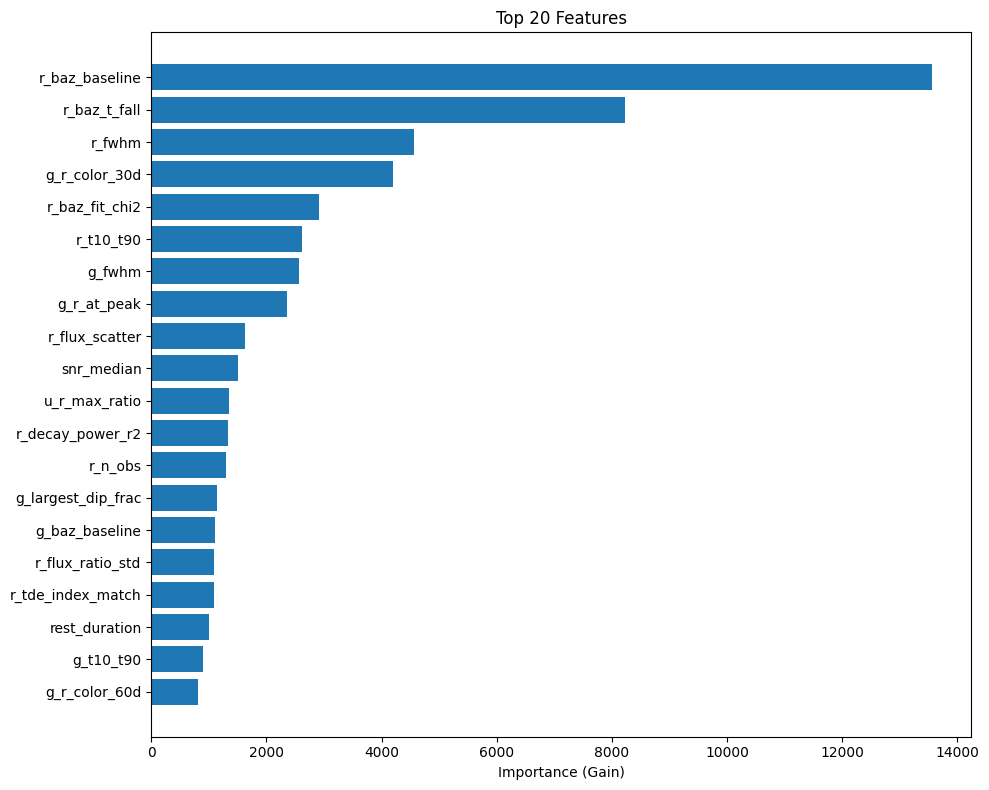

In [ ]:
# CELL 15: Feature Importance
print("="*70)
print("TOP 25 FEATURES (by LightGBM gain)")
print("="*70)

importance = lgb_model.feature_importance(importance_type='gain')
imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

print(imp_df.head(25).to_string(index=False))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(imp_df['feature'].head(20)[::-1], imp_df['importance'].head(20)[::-1])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Features')
plt.tight_layout()
plt.show()

In [ ]:
# CELL 16: Create Submissions
print("="*70)
print("CREATING SUBMISSIONS")
print("="*70)

# Best ensemble
test_probs = best_config['lgb_w'] * test_lgb + best_config['xgb_w'] * test_xgb
best_t = best_config['threshold']

predictions = (test_probs > best_t).astype(int)
print(f"\nBest config predictions:")
print(f"   Threshold: {best_t:.3f}")
print(f"   Predicted TDEs: {predictions.sum()} ({100*predictions.mean():.2f}%)")

# Main submission
submission = pd.DataFrame({
    'object_id': test_df['object_id'],
    'prediction': predictions
})
submission.to_csv('/content/submission_v5_golden.csv', index=False)
print(f"\n✅ Saved submission_v5_golden.csv")

# Alternative thresholds around best
print("\nAlternative submissions:")
for t_offset in [-0.05, -0.02, 0.02, 0.05]:
    t = best_t + t_offset
    if 0.05 <= t <= 0.5:
        preds_t = (test_probs > t).astype(int)
        sub_t = pd.DataFrame({'object_id': test_df['object_id'], 'prediction': preds_t})
        fname = f'/content/submission_v5_t{int(t*100):02d}.csv'
        sub_t.to_csv(fname, index=False)
        print(f"  t={t:.2f}: {preds_t.sum()} TDEs ({100*preds_t.mean():.2f}%)")

CREATING SUBMISSIONS

Best config predictions:
   Threshold: 0.290
   Predicted TDEs: 425 (5.96%)

✅ Saved submission_v5_golden.csv

Alternative submissions:
  t=0.24: 478 TDEs (6.70%)
  t=0.27: 441 TDEs (6.18%)
  t=0.31: 409 TDEs (5.73%)
  t=0.34: 384 TDEs (5.38%)


In [ ]:
# CELL 17: Download
from google.colab import files
print("📥 Downloading main submission...")
files.download('/content/submission_v5_golden.csv')

📥 Downloading main submission...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# CELL 18: Summary
print("\n" + "="*70)
print("🌟 V5 GOLDEN FEATURES SUMMARY")
print("="*70)
print(f"""
Strategy: Physics-based feature engineering, NO augmentation

Golden Features Added:
1. SHAPE: rise_time, decay_time, asymmetry, FWHM, t10-t90
2. POWER-LAW: decay_power_index, tde_index_match (vs t^-5/3)
3. COLOR: u_r ratios, g_r_at_peak, color evolution
4. STOCHASTICITY: flux_scatter, chi2_smooth, n_local_peaks
5. BAZIN FIT: t_fall, t_rise, rise_fall_ratio

Results:
- OOF F1: {best_f1:.4f}
- Optimal threshold: {best_config['threshold']:.3f}
- LGB weight: {best_config['lgb_w']}
- Predicted TDEs: {predictions.sum()}

Comparison:
- V2 (baseline): 0.63
- V3 (50x aug): 0.40 ❌
- V4 (3x aug): 0.618
- V5 (golden): {best_f1:.4f}

Top discriminative features (check importance plot):
- Look for color features (u_r, g_r) → TDE is blue
- Look for asymmetry features → TDE has long decay
- Look for stochasticity features → TDE is smooth
""")


🌟 V5 GOLDEN FEATURES SUMMARY

Strategy: Physics-based feature engineering, NO augmentation

Golden Features Added:
1. SHAPE: rise_time, decay_time, asymmetry, FWHM, t10-t90
2. POWER-LAW: decay_power_index, tde_index_match (vs t^-5/3)
3. COLOR: u_r ratios, g_r_at_peak, color evolution
4. STOCHASTICITY: flux_scatter, chi2_smooth, n_local_peaks
5. BAZIN FIT: t_fall, t_rise, rise_fall_ratio

Results:
- OOF F1: 0.5505
- Optimal threshold: 0.290
- LGB weight: 0.6
- Predicted TDEs: 425

Comparison:
- V2 (baseline): 0.63
- V3 (50x aug): 0.40 ❌
- V4 (3x aug): 0.618
- V5 (golden): 0.5505

Top discriminative features (check importance plot):
- Look for color features (u_r, g_r) → TDE is blue
- Look for asymmetry features → TDE has long decay
- Look for stochasticity features → TDE is smooth

